In [3]:
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
import pandas as pd

df_preds = pd.read_csv('test_predictions.csv')
# Prediction Probility "Error"

df_indicators = pd.read_csv('country_indicators.csv')

In [4]:
df = df_preds.merge(df_indicators, left_on='iso3', right_on='iso3', how='inner')
df

,yearmonth,fips,y_pred_transformer,y_pred_proba_transformer,y_true_transformer,y_pred_xgboost,y_pred_proba_xgboost,y_true_xgboost,y_pred_ffnn,y_pred_proba_ffnn,...,fsi_e3:_human_flight_and_brain_drain,fsi_e2:_economic_inequality,fsi_e1:_economy,fsi_p1:_state_legitimacy,fsi_p2:_public_services,fsi_p3:_human_rights,fsi_c1:_security_apparatus,fsi_c2:_factionalized_elites,fsi_x1:_external_intervention,fsi_category
0,202211,FJ,False,0.183897,False,False,0.066500,False,False,0.409958,...,7.6,5.0,7.5,6.1,4.2,5.4,6.4,8.2,6.6,Warning
1,202212,FJ,False,0.267831,False,False,0.099643,False,False,0.406696,...,7.6,5.0,7.5,6.1,4.2,5.4,6.4,8.2,6.6,Warning
2,202211,TZ,False,0.482585,False,True,0.704086,True,True,0.545236,...,6.4,7.3,6.2,6.9,8.4,5.6,4.6,6.5,6.0,Warning
3,202212,TZ,False,0.187792,False,True,0.638444,True,True,0.534560,...,6.4,7.3,6.2,6.9,8.4,5.6,4.6,6.5,6.0,Warning
4,202301,TZ,True,0.539319,True,True,0.608380,False,True,0.538583,...,6.4,7.3,6.2,6.9,8.4,5.6,4.6,6.5,6.0,Warning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,202211,MJ,False,0.182196,False,False,0.079453,False,False,0.291874,...,5.4,2.4,5.8,3.9,3.8,2.9,4.0,6.5,6.3,Stable
360,202212,MJ,False,0.203236,False,False,0.060189,False,False,0.300321,...,5.4,2.4,5.8,3.9,3.8,2.9,4.0,6.5,6.3,Stable
361,202211,TD,True,0.527107,False,True,0.697625,True,False,0.335496,...,6.8,4.7,3.9,3.5,4.3,3.5,7.3,5.6,3.3,Stable
362,202212,TD,True,0.555677,False,True,0.729246,False,False,0.324000,...,6.8,4.7,3.9,3.5,4.3,3.5,7.3,5.6,3.3,Stable


In [14]:
categorical_cols = df.select_dtypes(include=['category', 'object']).columns
categorical_cols

Index(['fips', 'iso3', 'hdr_hdicode', 'hdr_region', 'wbi_income_group',
       'wbi_lending_category', 'wbi_other_(emu_or_hipc)', 'fsi_category'],
      dtype='object')

In [7]:
df['error_transformer'] = np.abs(df.y_true_transformer-df.y_pred_proba_transformer)
df['error_ffnn'] = np.abs(df.y_true_ffnn-df.y_pred_proba_ffnn)
df['error_xgboost'] = np.abs(df.y_true_xgboost-df.y_pred_proba_xgboost)

In [8]:
df_cols = pd.DataFrame(df.dtypes, columns=('coldtype',)).reset_index().rename(columns={'index': 'colname'})
df_cols['coldtype'] = df_cols['coldtype'].astype('string')
# adjusting a potentially useful variable that might be considered label
df['fsi_rank'] = df['fsi_rank'].astype('string').str.replace(r'\D', '', regex=True).replace('', pd.NA)
# get list of numeric variables
num_vars = df_cols.query("coldtype=='float64'")['colname'].values
# these could be useful; but, I'm ignoring them for now to keep the demonstration simpler...

import itertools

# Indicator variables are often called "one hot" encodings
def one_hot(df, cols):
    """ One-hot encode given `cols` and add as new columns
        to `df`
        
        Returns tuple of `df` with new columns and list of
        new column names.
    """
    new_cols = list()
    new_col_names = list()
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each)
        new_cols.append(dummies)
        new_col_names.append(dummies.columns.values)

    df = pd.concat([df]+new_cols, axis=1)
    new_col_names = list(itertools.chain.from_iterable(new_col_names))
    return df, new_col_names

cat_vars = ['fsi_category', 'hdr_hdicode', 'hdr_region',
            'wbi_income_group', 'wbi_lending_category',
            'wbi_other_(emu_or_hipc)']

# get one hot encodings
df_oh, oh_cols = one_hot(df, cat_vars)
df_oh = df_oh.drop(columns=cat_vars)

df_oh[['error_transformer','error_ffnn','error_xgboost'] + oh_cols]

,error_transformer,error_ffnn,error_xgboost,fsi_category_Alert,fsi_category_Stable,fsi_category_Sustainable,fsi_category_Warning,hdr_hdicode_High,hdr_hdicode_Low,hdr_hdicode_Medium,...,hdr_region_SSA,wbi_income_group_High income,wbi_income_group_Low income,wbi_income_group_Lower middle income,wbi_income_group_Upper middle income,wbi_lending_category_Blend,wbi_lending_category_IBRD,wbi_lending_category_IDA,wbi_other_(emu_or_hipc)_EMU,wbi_other_(emu_or_hipc)_HIPC
0,0.183897,0.409958,0.066500,0,0,0,1,1,0,0,...,0,0,0,0,1,1,0,0,0,0
1,0.267831,0.406696,0.099643,0,0,0,1,1,0,0,...,0,0,0,0,1,1,0,0,0,0
2,0.482585,0.545236,0.295914,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,1
3,0.187792,0.534560,0.361556,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,1
4,0.460681,0.461417,0.608380,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,0.182196,0.291874,0.079453,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
360,0.203236,0.300321,0.060189,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
361,0.527107,0.335496,0.302375,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
362,0.555677,0.324000,0.729246,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


In [15]:
reduced_oh_cols = \
['fsi_category_Alert',
 'fsi_category_Sustainable',
 'fsi_category_Warning',
 'hdr_hdicode_High',
 'hdr_hdicode_Very High',
 'hdr_hdicode_Medium',
 'hdr_region_AS',
 'hdr_region_EAP',
 'hdr_region_ECA',
 'hdr_region_LAC',
 'hdr_region_SA',
 'wbi_income_group_Low income',
 'wbi_income_group_Lower middle income',
 'wbi_income_group_Upper middle income',
 'wbi_lending_category_Blend',
 'wbi_lending_category_IDA',
 'wbi_other_(emu_or_hipc)_EMU']

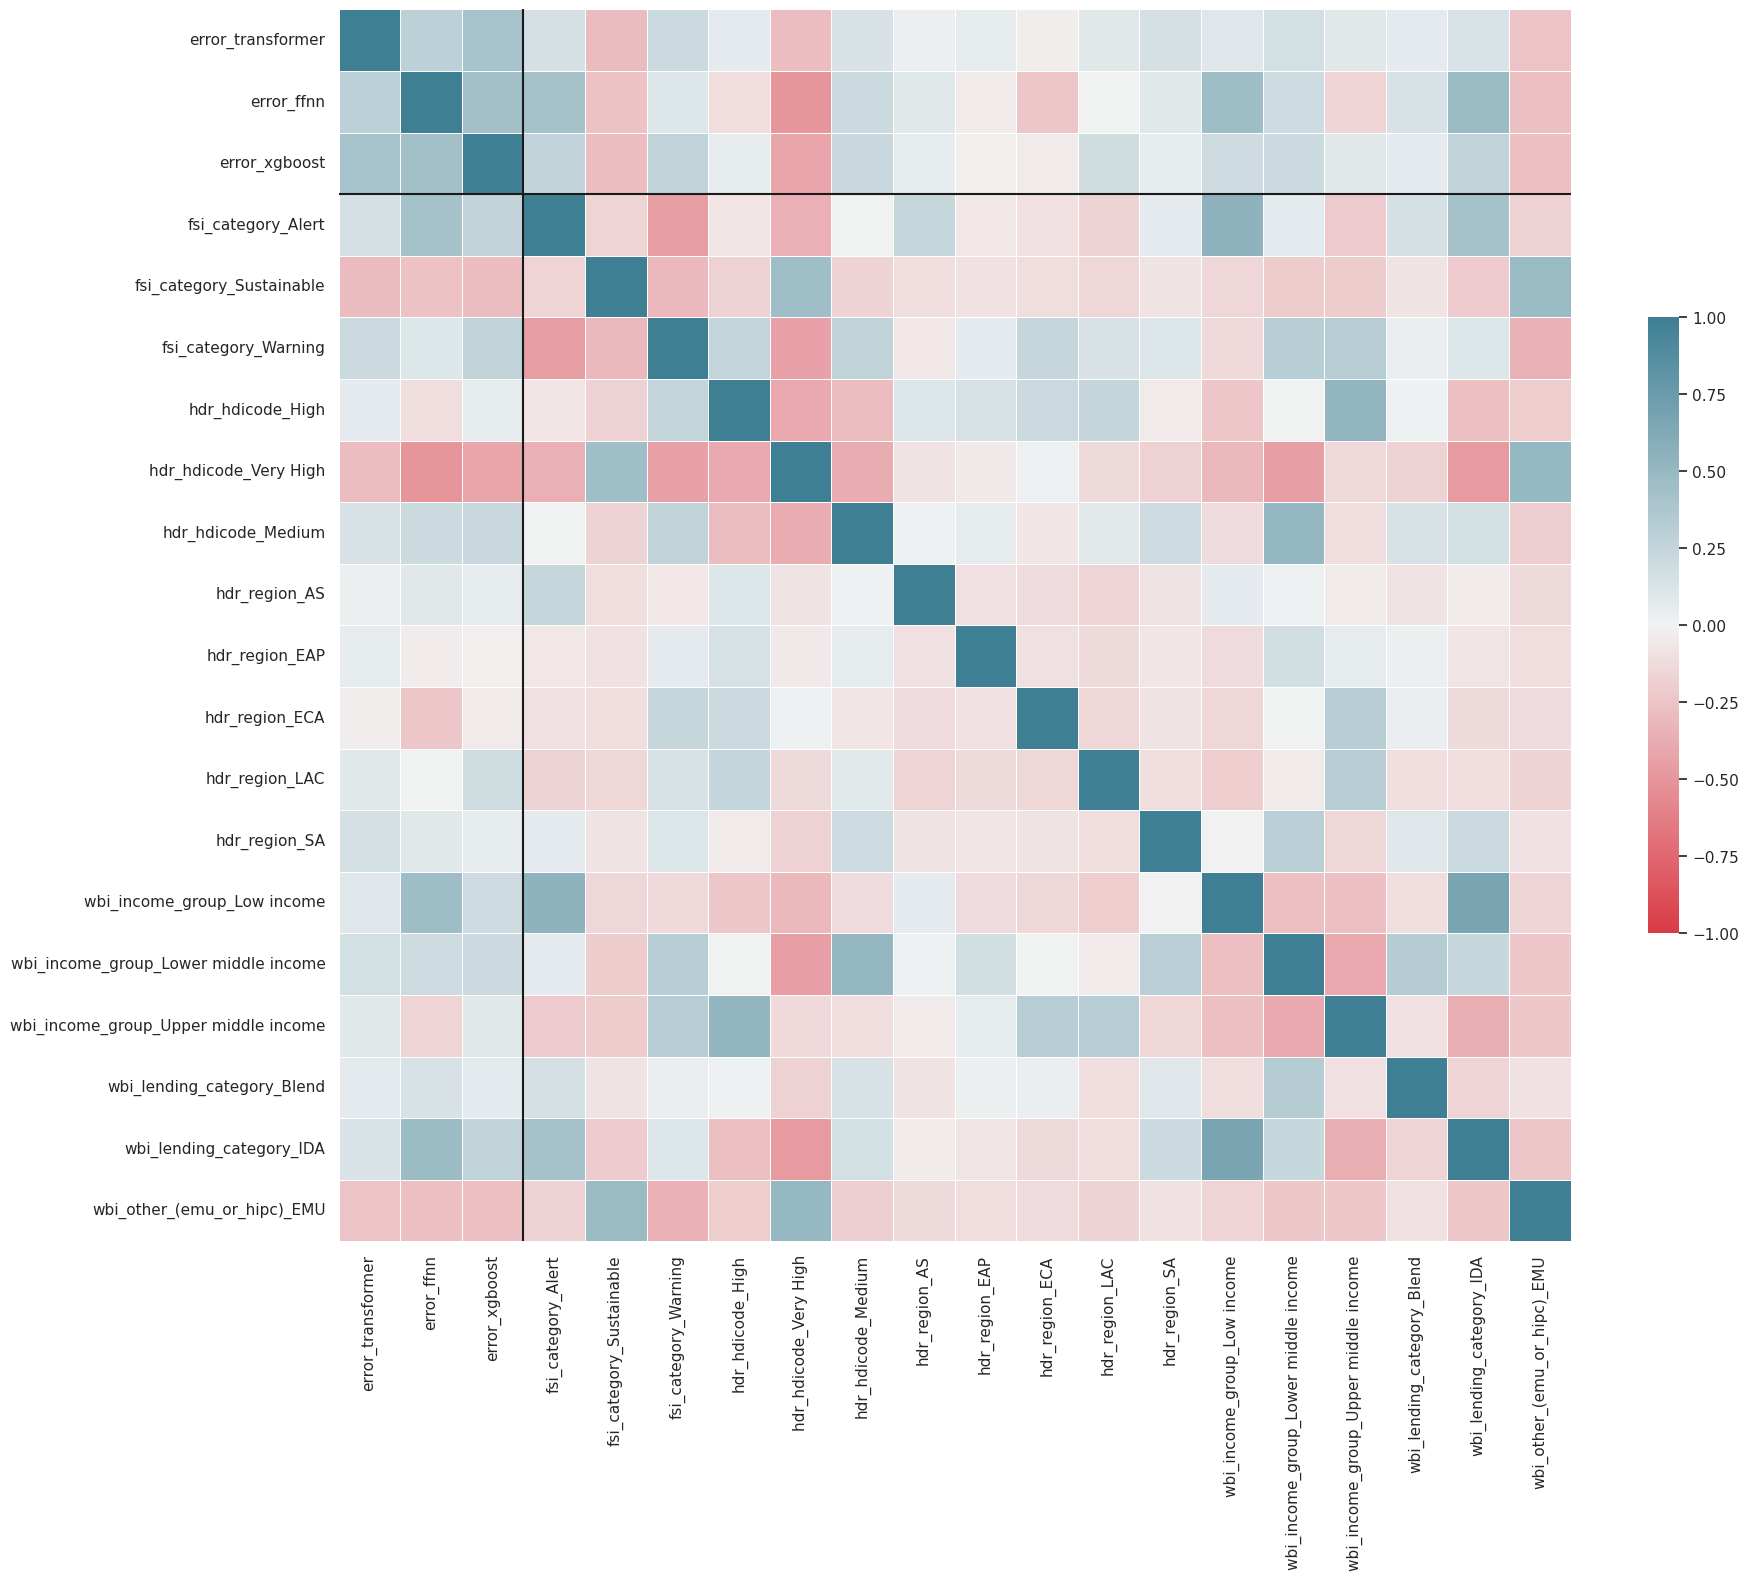

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# A good function from Evan Wheeler I've edited just a little bit 
def corr_heatmap(df):
    # plot correlation heatmap based on code from:
    # https://medium.com/@nikolh92/helpful-visualisations-for-linear-regression-646a5648ad9d
    sns.set(style="white")
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=bool)
    #mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(20, 16))
    cmap = sns.diverging_palette(10, 220, as_cmap=True)
    return sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, square=True,
                       linewidths=.5, annot=False, cbar_kws={"shrink": .5})

corr_heatmap(df_oh[['error_transformer','error_ffnn','error_xgboost'] + reduced_oh_cols])
_ = plt.axhline(y=3, c='k'); plt.axvline(x=3, c='k')

In [18]:
# This will be used to make the (additional) indicator variables of which model a prediction corresponds to
df_oh['model_transformer'] = df_oh['error_transformer'].astype(str)*0+"transformer"
df_oh['model_ffnn'] = df_oh['error_ffnn'].astype(str)*0+"ffnn"
df_oh['model_xgboost'] = df_oh['error_xgboost'].astype(str)*0+"xgboost"

# The amount of error might change depending on if the prediction is positive or negative
# so this indicates if it was a postive or negative prediction
df_oh['prediction_transformer'] = df.y_true_transformer.astype(int)
df_oh['prediction_ffnn'] = df.y_pred_ffnn.astype(int)
df_oh['prediction_xgboost'] = df.y_true_xgboost.astype(int)

# This "stacks" all the predictions together on top of each other so they can all be analyzed together:
# (make sure you understand what this is actually doing and why!)
design_matrix = \
pd.concat([df_oh[['error_transformer', 'model_transformer', 'prediction_transformer']+reduced_oh_cols].rename(columns={'error_transformer':'error','model_transformer':'model','prediction_transformer':'predicts1'}),
           df_oh[['error_ffnn', 'model_ffnn', 'prediction_ffnn']+reduced_oh_cols].rename(columns={'error_ffnn':'error','model_ffnn':'model','prediction_ffnn':'predicts1'}),
           df_oh[['error_xgboost', 'model_xgboost', 'prediction_xgboost']+reduced_oh_cols].rename(columns={'error_xgboost':'error','model_xgboost':'model','prediction_xgboost':'predicts1'})],
          ignore_index=True)

# 0. design_matrix[reduced_oh_cols] effects at "baseline" (`ffnn` predicts 0)

# 1. design_matrix[reduced_oh_cols]*predicts1 offset changes to "baseline" when prediction is 1
design_matrix.predicts1 # is the intercept offset
for x in reduced_oh_cols:
    design_matrix[x+' X predicts1'] = design_matrix[x]*design_matrix['predicts1']

# 2. design_matrix[reduced_oh_cols]*`transformer`/`xgboost` additional offset changes to "baseline"
# when prediction is made by `transformer`/`xgboost` for any prediction (0 or 1)
design_matrix['transformer'] = (design_matrix['model']=="transformer").astype(int) # intercept offset
design_matrix['xgboost'] = (design_matrix['model']=="xgboost").astype(int) # intercept offset
for x in reduced_oh_cols:
    design_matrix[x+' X transformer'] = design_matrix[x]*design_matrix['transformer']
    design_matrix[x+' X xgboost'] = design_matrix[x]*design_matrix['xgboost']

# 3. design_matrix[reduced_oh_cols]*`transformer_predicts1`/`xgboost_predicts1` 
# additional offset changes to "baseline" for non `ffnn` 1 predictions      
design_matrix['transformer X predicts1'] = design_matrix['transformer']*design_matrix['predicts1']
design_matrix['xgboost X predicts1'] = design_matrix['xgboost']*design_matrix['predicts1']
for x in reduced_oh_cols:
    design_matrix[x+' X transformer X predicts1'] = design_matrix[x]*design_matrix['transformer X predicts1']
    design_matrix[x+' X xgboost X predicts1'] = design_matrix[x]*design_matrix['xgboost X predicts1']

# This is to address the "DataFrame is highly fragmented" warning that's being flagged below
design_matrix = design_matrix.copy()
y = design_matrix['error']
del design_matrix['error']
del design_matrix['model']
design_matrix#.columns

,predicts1,fsi_category_Alert,fsi_category_Sustainable,fsi_category_Warning,hdr_hdicode_High,hdr_hdicode_Very High,hdr_hdicode_Medium,hdr_region_AS,hdr_region_EAP,hdr_region_ECA,...,wbi_income_group_Lower middle income X transformer X predicts1,wbi_income_group_Lower middle income X xgboost X predicts1,wbi_income_group_Upper middle income X transformer X predicts1,wbi_income_group_Upper middle income X xgboost X predicts1,wbi_lending_category_Blend X transformer X predicts1,wbi_lending_category_Blend X xgboost X predicts1,wbi_lending_category_IDA X transformer X predicts1,wbi_lending_category_IDA X xgboost X predicts1,wbi_other_(emu_or_hipc)_EMU X transformer X predicts1,wbi_other_(emu_or_hipc)_EMU X xgboost X predicts1
0,0,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1088,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1089,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1090,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
import statsmodels.api as sm

model_0_variables = design_matrix.columns.tolist()
model_0 = sm.OLS(y, sm.add_constant(design_matrix[model_0_variables]))
model_0.fit().summary().tables[-1]

Omnibus:,26.496,Durbin-Watson:,1.443
Prob(Omnibus):,0.000,Jarque-Bera (JB):,55.692
Skew:,0.053,Prob(JB):,8.07e-13
Kurtosis:,4.101,Cond. No.,1.87e+16


In [26]:
design_matrix.loc[:,design_matrix.sum()>16].shape

(1092, 73)

In [34]:
model_1_variables = design_matrix.loc[:,design_matrix.sum()>16].columns.tolist()
model_1 = sm.OLS(y, sm.add_constant(design_matrix[model_1_variables]))
model_1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  error   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     9.114
Date:                Tue, 05 Dec 2023   Prob (F-statistic):           1.21e-71
Time:                        22:24:28   Log-Likelihood:                 614.65
No. Observations:                1092   AIC:                            -1077.
Df Residuals:                    1016   BIC:                            -697.6
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
==================================================================================================================================
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
const                                                              0.2903      0.071      4.115      0.000       0.152       0.429
predicts1                                                          0.7280      0.141      5.174      0.000       0.452       1.004
fsi_category_Alert                                                 0.0549      0.047      1.158      0.247      -0.038       0.148
fsi_category_Sustainable                                          -0.0106      0.032     -0.337      0.736      -0.073       0.051
fsi_category_Warning                                               0.0277      0.031      0.901      0.368      -0.033       0.088
hdr_hdicode_High                                                   0.0490      0.059      0.829      0.407      -0.067       0.165
hdr_hdicode_Very High                                              0.0431      0.068      0.634      0.526      -0.090       0.176
hdr_hdicode_Medium                                                 0.0905      0.059      1.537      0.125      -0.025       0.206
hdr_region_AS                                                      0.0048      0.033      0.146      0.884      -0.060       0.070
hdr_region_EAP                                                    -0.0120      0.037     -0.321      0.748      -0.085       0.061
hdr_region_ECA                                                    -0.0756      0.036     -2.113      0.035      -0.146      -0.005
hdr_region_LAC                                                     0.0202      0.028      0.722      0.470      -0.035       0.075
hdr_region_SA                                                     -0.0107      0.039     -0.276      0.783      -0.087       0.066
wbi_income_group_Low income                                        0.2714      0.129      2.098      0.036       0.018       0.525
wbi_income_group_Lower middle income                               0.0415      0.056      0.742      0.458      -0.068       0.151
wbi_income_group_Upper middle income                               0.0328      0.045      0.737      0.461      -0.055       0.120
wbi_lending_category_Blend                                         0.0717      0.056      1.282      0.200      -0.038       0.181
wbi_lending_category_IDA                                          -0.0014      0.034     -0.040      0.968      -0.069       0.066
wbi_other_(emu_or_hipc)_EMU                                        0.0033      0.031      0.106      0.916      -0.057       0.064
fsi_category_Alert X predicts1                                    -0.2927      0.082     -3.566      0.000      -0.454      -0.132
fsi_category_Warning X predicts1                                  -0.3

In [38]:
model_2_variables = model_1_variables.copy()

model_2_variables.remove('fsi_category_Sustainable')
model_2_variables.remove('hdr_hdicode_High')
model_2_variables.remove('hdr_hdicode_Very High')
model_2_variables.remove('hdr_region_AS')
model_2_variables.remove('hdr_region_EAP')
model_2_variables.remove('hdr_region_SA')
model_2_variables.remove('wbi_lending_category_IDA')
model_2_variables.remove('wbi_other_(emu_or_hipc)_EMU')
model_2_variables.remove('hdr_hdicode_High X predicts1')
model_2_variables.remove('hdr_region_AS X predicts1')
model_2_variables.remove('wbi_lending_category_IDA X predicts1')
model_2_variables.remove('transformer')
model_2_variables.remove('fsi_category_Sustainable X xgboost')
model_2_variables.remove('hdr_hdicode_High X xgboost')
model_2_variables.remove('hdr_hdicode_Very High X transformer')
model_2_variables.remove('hdr_hdicode_Medium X xgboost')
model_2_variables.remove('hdr_region_EAP X transformer')
model_2_variables.remove('hdr_region_ECA X transformer')
model_2_variables.remove('hdr_region_ECA X xgboost')
model_2_variables.remove('hdr_region_LAC X transformer')
model_2_variables.remove('wbi_income_group_Low income X xgboost')
model_2_variables.remove('wbi_other_(emu_or_hipc)_EMU X xgboost')
model_2_variables.remove('wbi_income_group_Lower middle income')
model_2_variables.remove('wbi_income_group_Upper middle income')

model_2 = sm.OLS(y, sm.add_constant(design_matrix[model_2_variables]))
model_2.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  error   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     13.38
Date:                Tue, 05 Dec 2023   Prob (F-statistic):           3.80e-82
Time:                        22:37:18   Log-Likelihood:                 609.13
No. Observations:                1092   AIC:                            -1114.
Df Residuals:                    1040   BIC:                            -854.5
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
==================================================================================================================================
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
const                                                              0.3417      0.011     30.006      0.000       0.319       0.364
predicts1                                                          0.6593      0.110      6.003      0.000       0.444       0.875
fsi_category_Alert                                                 0.0802      0.033      2.462      0.014       0.016       0.144
fsi_category_Warning                                               0.0517      0.018      2.835      0.005       0.016       0.088
hdr_hdicode_Medium                                                 0.0476      0.017      2.809      0.005       0.014       0.081
hdr_region_ECA                                                    -0.0735      0.017     -4.341      0.000      -0.107      -0.040
hdr_region_LAC                                                     0.0251      0.016      1.565      0.118      -0.006       0.057
wbi_income_group_Low income                                        0.1929      0.052      3.688      0.000       0.090       0.295
wbi_lending_category_Blend                                         0.0800      0.052      1.547      0.122      -0.021       0.181
fsi_category_Alert X predicts1                                    -0.2597      0.075     -3.448      0.001      -0.407      -0.112
fsi_category_Warning X predicts1                                  -0.2978      0.088     -3.394      0.001      -0.470      -0.126
hdr_hdicode_Very High X predicts1                                 -0.1816      0.082     -2.207      0.028      -0.343      -0.020
hdr_hdicode_Medium X predicts1                                    -0.0755      0.042     -1.790      0.074      -0.158       0.007
hdr_region_LAC X predicts1                                        -0.0611      0.045     -1.367      0.172      -0.149       0.027
wbi_income_group_Low income X predicts1                           -0.4511      0.098     -4.620      0.000      -0.643      -0.260
wbi_income_group_Lower middle income X predicts1                  -0.2178      0.099     -2.197      0.028      -0.412      -0.023
wbi_income_group_Upper middle income X predicts1                  -0.2516      0.087     -2.902      0.004      -0.422      -0.081
wbi_lending_category_Blend X predicts1                            -0.1415      0.051     -2.782      0.005      -0.241      -0.042
xgboost                                                           -0.1698      0.039     -4.392      0.000      -0.246      -0.094
fsi_category_Alert X transformer                                   0.0818      0.052      1.572      0.116      -0.020       0.184
fsi_category_Alert X xgboost                                       0.2

In [71]:
model_3_variables = model_2_variables.copy()

model_3_variables.remove('hdr_region_LAC')
model_3_variables.remove('wbi_lending_category_Blend')
model_3_variables.remove('hdr_region_LAC X predicts1')
model_3_variables.remove('fsi_category_Alert X transformer')
model_3_variables.remove('hdr_region_AS X transformer')
model_3_variables.remove('hdr_region_AS X xgboost')
model_3_variables.remove('wbi_income_group_Low income X transformer')
model_3_variables.remove('wbi_lending_category_Blend X transformer')
model_3_variables.remove('wbi_lending_category_Blend X xgboost')
model_3_variables.remove('wbi_lending_category_IDA X xgboost')
model_3_variables.remove('wbi_other_(emu_or_hipc)_EMU X transformer')
model_3_variables.remove('transformer X predicts1')
model_3_variables.remove('fsi_category_Warning X transformer X predicts1')
model_3_variables.remove('fsi_category_Warning X xgboost X predicts1')
model_3_variables.remove('hdr_hdicode_Medium X transformer X predicts1')
model_3_variables.remove('hdr_hdicode_Medium X xgboost X predicts1')
model_3_variables.remove('hdr_hdicode_Medium X predicts1')
model_3_variables.remove('fsi_category_Warning X transformer')
model_3_variables.remove('hdr_region_EAP X xgboost')
model_3_variables.remove('hdr_region_SA X xgboost')
model_3_variables.remove('fsi_category_Alert')
model_3_variables.remove('hdr_hdicode_Very High X predicts1')
model_3_variables.remove('wbi_income_group_Lower middle income X predicts1')
model_3_variables.remove('fsi_category_Sustainable X transformer')
model_3_variables.remove('hdr_hdicode_High X transformer')
model_3_variables.remove('hdr_hdicode_Very High X xgboost')
model_3_variables.remove('hdr_region_LAC X xgboost')
model_3_variables.remove('hdr_region_SA X transformer')
model_3_variables.remove('wbi_income_group_Upper middle income X transformer')
model_3_variables.remove('wbi_income_group_Lower middle income X transformer X predicts1')
model_3_variables.remove('wbi_income_group_Lower middle income X xgboost X predicts1')
model_3_variables.remove('wbi_lending_category_IDA X transformer X predicts1')


model_3 = sm.OLS(y, sm.add_constant(design_matrix[model_3_variables]))
model_3.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  error   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     23.94
Date:                Wed, 06 Dec 2023   Prob (F-statistic):           2.35e-69
Time:                        00:00:28   Log-Likelihood:                 526.84
No. Observations:                1092   AIC:                            -1014.
Df Residuals:                    1072   BIC:                            -913.8
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
const                                                  0.3605      0.009     40.369      0.000       0.343       0.378
predicts1                                              0.3246      0.038      8.561      0.000       0.250       0.399
fsi_category_Warning                                   0.0697      0.013      5.246      0.000       0.044       0.096
hdr_hdicode_Medium                                     0.0419      0.015      2.827      0.005       0.013       0.071
hdr_region_ECA                                        -0.0657      0.016     -4.081      0.000      -0.097      -0.034
wbi_income_group_Low income                            0.1477      0.026      5.687      0.000       0.097       0.199
fsi_category_Alert X predicts1                        -0.2051      0.046     -4.450      0.000      -0.295      -0.115
fsi_category_Warning X predicts1                      -0.2834      0.039     -7.178      0.000      -0.361      -0.206
wbi_income_group_Low income X predicts1               -0.1020      0.038     -2.712      0.007      -0.176      -0.028
wbi_income_group_Upper middle income X predicts1       0.0384      0.036      1.061      0.289      -0.033       0.109
wbi_lending_category_Blend X predicts1                -0.0840      0.038     -2.189      0.029      -0.159      -0.009
xgboost                                               -0.1026      0.017     -6.027      0.000      -0.136      -0.069
fsi_category_Alert X xgboost                           0.1889      0.030      6.374      0.000       0.131       0.247
fsi_category_Warning X xgboost                         0.1096      0.028      3.856      0.000       0.054       0.165
hdr_hdicode_Medium X transformer                      -0.0438      0.026     -1.661      0.097      -0.096       0.008
wbi_income_group_Lower middle income X transformer     0.0970      0.022      4.396      0.000       0.054       0.140
wbi_income_group_Lower middle income X xgboost         0.1068      0.028      3.782      0.000       0.051       0.162
wbi_income_group_Upper middle income X xgboost         0.0981      0.026      3.778      0.000       0.047       0.149
wbi_lending_category_IDA X transformer                -0.0412      0.022     -1.898      0.058      -0.084       0.001
xgboost X predicts1                                   -0.2050      0.029     -7.132      0.000      -0.261      -0.149
==============================================================================
Omnibus:                       12.014   Durbin-Watson:                   1.421
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.110
Skew:                           0.171   Prob(JB):                     0.000863
Kurtosis:                     

In [73]:
model_4_variables = model_3_variables.copy()

model_4_variables.remove('hdr_hdicode_Medium')
model_4_variables.remove('wbi_income_group_Low income X predicts1')
model_4_variables.remove('wbi_income_group_Upper middle income X predicts1')
model_4_variables.remove('wbi_lending_category_Blend X predicts1')
model_4_variables.remove('hdr_hdicode_Medium X transformer')
model_4_variables.remove('wbi_lending_category_IDA X transformer')

model_4 = sm.OLS(y, sm.add_constant(design_matrix[model_4_variables]))
model_4.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  error   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     32.81
Date:                Wed, 06 Dec 2023   Prob (F-statistic):           3.47e-69
Time:                        00:03:36   Log-Likelihood:                 515.75
No. Observations:                1092   AIC:                            -1004.
Df Residuals:                    1078   BIC:                            -933.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
const                                                  0.3652      0.009     41.335      0.000       0.348       0.383
predicts1                                              0.3333      0.037      9.088      0.000       0.261       0.405
fsi_category_Warning                                   0.0729      0.013      5.612      0.000       0.047       0.098
hdr_region_ECA                                        -0.0708      0.016     -4.417      0.000      -0.102      -0.039
wbi_income_group_Low income                            0.0922      0.017      5.507      0.000       0.059       0.125
fsi_category_Alert X predicts1                        -0.2681      0.041     -6.593      0.000      -0.348      -0.188
fsi_category_Warning X predicts1                      -0.3163      0.038     -8.240      0.000      -0.392      -0.241
xgboost                                               -0.1036      0.017     -6.116      0.000      -0.137      -0.070
fsi_category_Alert X xgboost                           0.2289      0.026      8.659      0.000       0.177       0.281
fsi_category_Warning X xgboost                         0.1318      0.027      4.851      0.000       0.079       0.185
wbi_income_group_Lower middle income X transformer     0.0723      0.017      4.291      0.000       0.039       0.105
wbi_income_group_Lower middle income X xgboost         0.0988      0.026      3.822      0.000       0.048       0.150
wbi_income_group_Upper middle income X xgboost         0.0876      0.024      3.597      0.000       0.040       0.135
xgboost X predicts1                                   -0.1942      0.028     -6.863      0.000      -0.250      -0.139
==============================================================================
Omnibus:                        7.491   Durbin-Watson:                   1.425
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                8.170
Skew:                           0.137   Prob(JB):                       0.0168
Kurtosis:                       3.324   Cond. No.                         17.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

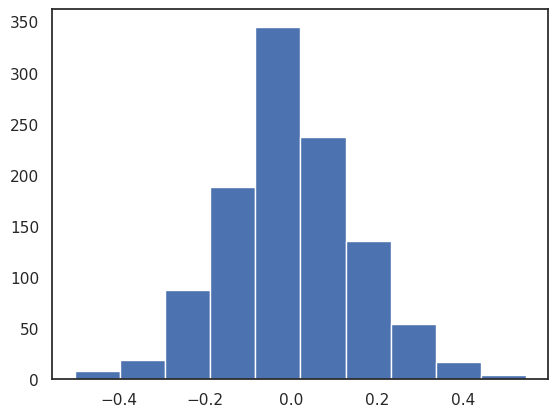

In [74]:
_ = plt.hist(y-model_4.fit().predict())

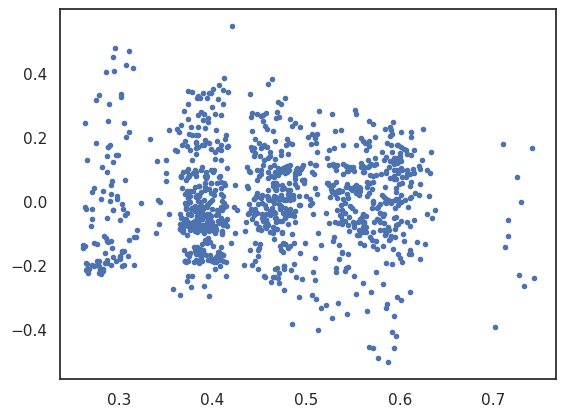

In [75]:
_ = plt.plot(model_4.fit().predict()+0.05*np.random.uniform(size=len(y)), y-model_4.fit().predict(), '.')

In [76]:
train_size = 800
data_indices = np.random.choice(design_matrix.index, size=design_matrix.shape[0], replace=False)
train_indices = data_indices[train_size:]
test_indices = data_indices[:train_size]

model_1_train_test_fit = sm.OLS(y[train_indices], sm.add_constant(design_matrix.iloc[train_indices][model_1_variables])).fit()
model_1_train_RMSE = ((y[train_indices] - model_1_train_test_fit.predict())**2).mean()**.5
model_1_test_RMSE = ((y[test_indices] - 
                      model_1_train_test_fit.predict(sm.add_constant(design_matrix.iloc[test_indices][model_1_variables]))
                     )**2).mean()**.5

model_2_train_test_fit = sm.OLS(y[train_indices], sm.add_constant(design_matrix.iloc[train_indices][model_2_variables])).fit()
model_2_train_RMSE = ((y[train_indices] - model_2_train_test_fit.predict())**2).mean()**.5
model_2_test_RMSE = ((y[test_indices] - 
                      model_2_train_test_fit.predict(sm.add_constant(design_matrix.iloc[test_indices][model_2_variables]))
                     )**2).mean()**.5

model_3_train_test_fit = sm.OLS(y[train_indices], sm.add_constant(design_matrix.iloc[train_indices][model_3_variables])).fit()
model_3_train_RMSE = ((y[train_indices] - model_3_train_test_fit.predict())**2).mean()**.5
model_3_test_RMSE = ((y[test_indices] - 
                      model_3_train_test_fit.predict(sm.add_constant(design_matrix.iloc[test_indices][model_3_variables]))
                     )**2).mean()**.5

model_4_train_test_fit = sm.OLS(y[train_indices], sm.add_constant(design_matrix.iloc[train_indices][model_4_variables])).fit()
model_4_train_RMSE = ((y[train_indices] - model_4_train_test_fit.predict())**2).mean()**.5
model_4_test_RMSE = ((y[test_indices] - 
                      model_4_train_test_fit.predict(sm.add_constant(design_matrix.iloc[test_indices][model_4_variables]))
                     )**2).mean()**.5

import plotly.express as px
px.bar(pd.DataFrame({'RMSE': [model_1_train_RMSE, model_2_train_RMSE, model_3_train_RMSE, model_4_train_RMSE] + 
                             [model_1_test_RMSE, model_2_test_RMSE, model_3_test_RMSE, model_4_test_RMSE],
                     'Score': ['Training']*4+['Testing']*4,
                     'Model': [1,2,3,4]+[1,2,3,4]}), 
       y='RMSE', x='Model', color='Score', barmode='group')

In [80]:
reps = 100
model_3_train_RMSEs = np.array([0.0]*reps)
model_4_train_RMSEs = np.array([0.0]*reps)
model_3_test_RMSEs = np.array([0.0]*reps)
model_4_test_RMSEs = np.array([0.0]*reps)
for i in range(reps):
    data_indices = np.random.choice(design_matrix.index, size=design_matrix.shape[0], replace=False)
    train_indices = data_indices[train_size:]
    test_indices = data_indices[:train_size]

    model_3_train_test_fit = sm.OLS(y[train_indices], sm.add_constant(design_matrix.iloc[train_indices][model_3_variables])).fit()
    model_3_train_RMSE = ((y[train_indices] - model_3_train_test_fit.predict())**2).mean()**.5
    model_3_test_RMSE = ((y[test_indices] - 
                          model_3_train_test_fit.predict(sm.add_constant(design_matrix.iloc[test_indices][model_3_variables]))
                         )**2).mean()**.5
    model_3_train_RMSEs[i] = model_3_train_RMSE
    model_3_test_RMSEs[i] = model_3_test_RMSE

    model_4_train_test_fit = sm.OLS(y[train_indices], sm.add_constant(design_matrix.iloc[train_indices][model_4_variables])).fit()
    model_4_train_RMSE = ((y[train_indices] - model_4_train_test_fit.predict())**2).mean()**.5
    model_4_test_RMSE = ((y[test_indices] - 
                          model_4_train_test_fit.predict(sm.add_constant(design_matrix.iloc[test_indices][model_4_variables]))
                         )**2).mean()**.5
    model_4_train_RMSEs[i] = model_4_train_RMSE
    model_4_test_RMSEs[i] = model_4_test_RMSE

In [79]:
px.scatter(pd.DataFrame({'Incresed Test RMSE': (model_3_test_RMSEs-model_4_train_RMSEs).tolist()+
                                               (model_4_test_RMSEs-model_4_train_RMSEs).tolist(),
                         'Training RMSE': model_3_train_RMSEs.tolist()+model_4_train_RMSEs.tolist(),
                         'Model': ["Model 3"]*reps+["Model 4"]*reps}),
           x='Training RMSE', y='Incresed Test RMSE', color='Model',
           marginal_x="box", marginal_y="violin")

In [81]:
import statsmodels.api as sm

exogs = df_oh[['predicts1', 'fsi_category_Alert', 'fsi_category_Warning', 'hdr_hdicode_Medium', 
            'hdr_region_ECA', 'wbi_income_group_Low_income', 
            'fsi_category_Alert X predicts1', 'fsi_category_Warning X predicts1', 
            'hdr_hdicode_Very High X predicts1', 'wbi_income_group_Low income X predicts1']]



KeyError: "None of [Index(['predicts1', 'fsi_category_Alert', 'fsi_category_Warning',\n       'hdr_hdicode_Medium', 'hdr_region_ECA', 'wbi_income_group_Low_income',\n       'fsi_category_Alert X predicts1', 'fsi_category_Warning X predicts1',\n       'hdr_hdicode_Very High X predicts1',\n       'wbi_income_group_Low income X predicts1'],\n      dtype='object')] are in the [columns]"